In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [4]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/coastal_protection_output_data/"

In [5]:
countrydata = pd.read_csv(myfolder+"country_output.csv")

In [6]:
originaldata = pd.read_csv(myfolder+"region_output_WB.csv")

In [7]:
countrydata.columns

Index(['locationid', 'locationname', 'rcp', 'ada', 'ssp', 'adacost',
       'riverprotection', 'time', 'rslr', 'par', 'pop_below_h100',
       'riverdike_cost', 'riverdike_maintenance_cost', 'seadike_cost',
       'seadike_maintenance_cost', 'seafloodcost', 'surge_barrier_cost',
       'surge_barrier_maintenance_cost', 'protection_investment_cost',
       'protection_maintenance_cost', 'gdp'],
      dtype='object')

In [8]:
countrydata.time.unique()

array([2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060,
       2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

In [9]:
mydata = countrydata.copy()

# redistributes investments that happen all in 2015 in the optimal strategy

In [10]:
inter = mydata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])["protection_investment_cost"].unstack("time").reset_index()

In [11]:
correct = inter.copy()

In [12]:
inter.loc[inter.ada=="CBA Protection",[2020,2025,2030,2035]] = correct.loc[correct.ada=="CBA Protection",[2020,2025,2030,2035]].add(1/5*correct.loc[correct.ada=="CBA Protection",2015],axis=0)
inter.loc[inter.ada=="CBA Protection",2015] = 1/5*correct.loc[correct.ada=="CBA Protection",2015]

In [13]:
inter = inter.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection']).stack("time").reset_index().rename(columns={0:"protection_investment_cost_corrected"})

In [14]:
mydata = mydata.merge(inter, on=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [15]:
mydata = mydata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [16]:
mydata.reset_index("time").time.unique()

array([2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060,
       2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

# discounts investments

In [17]:
mydata = mydata.reset_index("time")

In [18]:
#the annual numbers are averages so we multiply them by 5 when discounting
def discount_sum_over_5_years(row,name,d):
    return np.sum([row[name]*(1+d)**(1-(year-2015)) for year in np.arange(row["time"]-4,row["time"]+1)])

In [19]:
bigger_data = pd.DataFrame()
for d in [0.06]:
    for time_horizon in [2030]:
        temp = mydata.copy()
        temp = temp.loc[temp.time<=time_horizon,:]
        temp['protection_investment_cost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"protection_investment_cost_corrected",d),axis=1)
        temp['protection_maintenance_cost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"protection_maintenance_cost",d),axis=1)
        temp['seafloodcost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"seafloodcost",d),axis=1)
        temp['time_horizon'] = time_horizon
        temp['d'] = d
        bigger_data = bigger_data.append(temp)

In [20]:
newdata = bigger_data.loc[bigger_data.time>2010,:].set_index(['time','time_horizon','d'], append=True)[['protection_investment_cost_disc','protection_maintenance_cost_disc','seafloodcost_disc']]

# Calculates GDP ratios per country

In [21]:
mydata['protection_inv_over_gdp'] = mydata.protection_investment_cost_corrected/mydata.gdp
mydata['protection_maint_over_gdp'] = mydata.protection_maintenance_cost/mydata.gdp
mydata['protection_cost_over_gdp'] = mydata.protection_inv_over_gdp+mydata.protection_maint_over_gdp
mydata['residual_risk_over_gdp'] = mydata.seafloodcost/mydata.gdp
mydata['tot_cost_over_gdp'] = mydata.protection_cost_over_gdp+mydata.residual_risk_over_gdp

In [22]:
mydata.reset_index().ada.unique()

array(['Constant Abs. Flood Risk', 'Constant Rel. Flood Risk',
       'Risk intolerance', 'Constant Protection Levels', 'CBA Protection'],
      dtype=object)

# Appends countries with two different rules: one with all countries and one with countries with investments only (excludes developing countries with no coast)

In [23]:
sumcountries_inter = mydata.set_index("time",append=True)

## test contains the sum of all investments over time. if it's zero we can drop the country

In [24]:
test = sumcountries_inter.protection_investment_cost_corrected.unstack("time").sum(axis=1)

In [25]:
sumcountries_inter = sumcountries_inter.reset_index().merge(test.reset_index().rename(columns={0:"test"}),on=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])

## merges with WB country names and grouping definitions

In [26]:
codes = pd.read_csv(myfolder+"wbccodes2014.csv")

In [27]:
sumcountries_inter = sumcountries_inter.merge(codes.rename(columns={'country':'locationid'}),on='locationid')

In [28]:
sumcountries = sumcountries_inter.loc[sumcountries_inter.wbregion!="YHI",:]

In [29]:
sumallcountries = sumcountries_inter

In [30]:
sumcountries_inter.loc[(sumcountries_inter.test>0)&(sumcountries_inter.wbregion!="YHI")].locationname.unique().size

97

In [31]:
newdata = newdata.reset_index().merge(codes.rename(columns={'country':'locationid'}),on='locationid')

## list of countries with zero investments (excludes rich countries)

In [32]:
sumcountries.loc[sumcountries.test==0].locationname.unique()

array(['Afghanistan', 'Armenia', 'Azerbaijan', 'Burundi', 'Burkina Faso',
       'Bosnia and Herzegovia', 'Belarus', 'Bolivia', 'Bhutan',
       'Botswana', 'Central African Republic',
       'Congo, Democratic Republic', 'Eritrea', 'Ethiopia',
       'Micronesia, Federal State of', 'Gabon', 'Grenada', 'Honduras',
       'Hungary', 'Iraq', 'Jordan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan',
       'Cambodia', 'Saint Kitts and Nevis',
       'Lao Peoples Democratic Republic', 'Saint Lucia', 'Lesotho',
       'Moldova', 'Macedonia, FYR', 'Mali', 'Mongolia', 'Mauritania',
       'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nepal', 'Palau',
       'Paraguay', 'Rwanda', 'Sudan', 'Solomon Islands', 'Sierra Leone',
       'Serbia', 'South Sudan', 'Swaziland', 'Seychelles', 'Chad',
       'Tajikistan', 'Turkmenistan', 'Uganda', 'Uzbekistan', 'Zambia',
       'Zimbabwe'], dtype=object)

In [33]:
sumcoastcountries = sumcountries.loc[sumcountries.test>0]

In [34]:
byregions = sumcountries.set_index(['locationid','wbregionname', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])
byregions_coasts = sumcoastcountries.set_index(['locationid','wbregionname', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [35]:
byregions_includesrich = sumallcountries.set_index(['locationid','wbregionname', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [36]:
sumcountries = sumcountries.set_index(['locationid', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])
sumcoastcountries = sumcoastcountries.set_index(['locationid', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

## calculates GDP ratios for all countries with and without coastal countries

In [37]:
sumcountries['protection_inv_over_gdp'] = sumcountries.protection_investment_cost_corrected/sumcountries.gdp
sumcountries['protection_maint_over_gdp'] = sumcountries.protection_maintenance_cost/sumcountries.gdp
sumcountries['protection_cost_over_gdp'] = sumcountries.protection_inv_over_gdp+sumcountries.protection_maint_over_gdp
sumcountries['residual_risk_over_gdp'] = sumcountries.seafloodcost/sumcountries.gdp
sumcountries['tot_cost_over_gdp'] = sumcountries.protection_cost_over_gdp+sumcountries.residual_risk_over_gdp

sumcoastcountries['protection_inv_over_gdp'] = sumcoastcountries.protection_investment_cost_corrected/sumcoastcountries.gdp
sumcoastcountries['protection_maint_over_gdp'] = sumcoastcountries.protection_maintenance_cost/sumcoastcountries.gdp
sumcoastcountries['protection_cost_over_gdp'] = sumcoastcountries.protection_inv_over_gdp+sumcoastcountries.protection_maint_over_gdp
sumcoastcountries['residual_risk_over_gdp'] = sumcoastcountries.seafloodcost/sumcoastcountries.gdp
sumcoastcountries['tot_cost_over_gdp'] = sumcoastcountries.protection_cost_over_gdp+sumcoastcountries.residual_risk_over_gdp

## averages per year of the ratios for different time periods

In [38]:
average_per_year_sumcountries = pd.DataFrame()
for time_horizon in [[2010,2030],[2030,2050],[2050,2100]]:
    temp = sumcountries.copy().reset_index("time")
    temp = temp.loc[(temp.time<=time_horizon[1])&(temp.time>time_horizon[0]),:]
    temp['time_horizon'] = time_horizon[1]
    temp = temp.set_index(['time','time_horizon'], append=True)
    average_per_year_sumcountries = average_per_year_sumcountries.append(temp.mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time_horizon']))

In [39]:
average_per_year_sumcoastcountries = pd.DataFrame()
for time_horizon in [[2010,2030],[2030,2050],[2050,2100]]:
    temp = sumcoastcountries.copy().reset_index("time")
    temp = temp.loc[(temp.time<=time_horizon[1])&(temp.time>time_horizon[0]),:]
    temp['time_horizon'] = time_horizon[1]
    temp = temp.set_index(['time','time_horizon'], append=True)
    average_per_year_sumcoastcountries = average_per_year_sumcoastcountries.append(temp.mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time_horizon']))

## GDP ratios by WB region with and without coastal countries

In [40]:
byregions['protection_inv_over_gdp'] = byregions.protection_investment_cost_corrected/byregions.gdp
byregions['protection_maint_over_gdp'] = byregions.protection_maintenance_cost/byregions.gdp
byregions['protection_cost_over_gdp'] = byregions.protection_inv_over_gdp+byregions.protection_maint_over_gdp
byregions['residual_risk_over_gdp'] = byregions.seafloodcost/byregions.gdp
byregions['tot_cost_over_gdp'] = byregions.protection_cost_over_gdp+byregions.residual_risk_over_gdp

byregions_coasts['protection_inv_over_gdp'] = byregions_coasts.protection_investment_cost_corrected/byregions_coasts.gdp
byregions_coasts['protection_maint_over_gdp'] = byregions_coasts.protection_maintenance_cost/byregions_coasts.gdp
byregions_coasts['protection_cost_over_gdp'] = byregions_coasts.protection_inv_over_gdp+byregions_coasts.protection_maint_over_gdp
byregions_coasts['residual_risk_over_gdp'] = byregions_coasts.seafloodcost/byregions_coasts.gdp
byregions_coasts['tot_cost_over_gdp'] = byregions_coasts.protection_cost_over_gdp+byregions_coasts.residual_risk_over_gdp

In [41]:
byregions_includesrich['protection_inv_over_gdp'] = byregions_includesrich.protection_investment_cost_corrected/byregions_includesrich.gdp
byregions_includesrich['protection_maint_over_gdp'] = byregions_includesrich.protection_maintenance_cost/byregions_includesrich.gdp
byregions_includesrich['protection_cost_over_gdp'] = byregions_includesrich.protection_inv_over_gdp+byregions_includesrich.protection_maint_over_gdp
byregions_includesrich['residual_risk_over_gdp'] = byregions_includesrich.seafloodcost/byregions_includesrich.gdp
byregions_includesrich['tot_cost_over_gdp'] = byregions_includesrich.protection_cost_over_gdp+byregions_includesrich.residual_risk_over_gdp

# Results for the report (chapter 5)

## numbers for introduction and maintenance section

In [42]:
temp = average_per_year_sumcountries.reset_index("time_horizon")
100*temp.loc[temp.time_horizon==2030,["protection_inv_over_gdp","protection_maint_over_gdp"]].sum(axis=1).mean(level=['ada'])

ada
Constant Abs. Flood Risk      0.085765
Constant Rel. Flood Risk      0.053471
Risk intolerance              0.129432
Constant Protection Levels    0.051170
CBA Protection                0.133358
dtype: float64

In [43]:
100*temp.loc[temp.time_horizon==2030,["protection_inv_over_gdp","protection_maint_over_gdp"]].sum(axis=1).min(level=['ada'])

ada
Constant Abs. Flood Risk      0.039765
Constant Rel. Flood Risk      0.022861
Risk intolerance              0.062534
Constant Protection Levels    0.021807
CBA Protection                0.060536
dtype: float64

In [44]:
100*temp.loc[temp.time_horizon==2030,["protection_inv_over_gdp","protection_maint_over_gdp"]].sum(axis=1).max(level=['ada'])

ada
Constant Abs. Flood Risk      0.153291
Constant Rel. Flood Risk      0.096457
Risk intolerance              0.216805
Constant Protection Levels    0.093618
CBA Protection                0.259033
dtype: float64

In [45]:
100*temp.loc[temp.time_horizon==2030,["protection_inv_over_gdp","protection_maint_over_gdp"]].describe()

,protection_inv_over_gdp,protection_maint_over_gdp
count,18000.000000,18000.000000
mean,0.055141,0.035498
std,0.042692,0.016933
min,0.005421,0.015025
25%,0.022044,0.018552
50%,0.042636,0.036007
75%,0.077829,0.050722
max,0.189647,0.069412


### maintenance section

In [46]:
temp = sumcoastcountries.protection_maint_over_gdp.mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])

In [47]:
100*temp.describe()

count    18000.000000
mean         0.021313
std          0.010622
min          0.007863
25%          0.011814
50%          0.020407
75%          0.030396
max          0.043055
Name: protection_maint_over_gdp, dtype: float64

## figure 5.2

C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


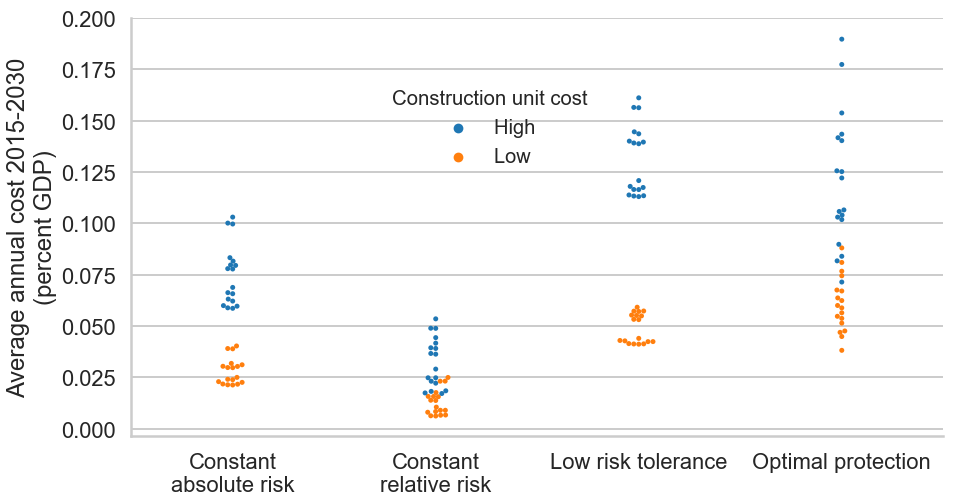

In [52]:
time_horizon = 2030

toplot = average_per_year_sumcountries
toplot = toplot.reset_index()
toplot = toplot.loc[toplot.time_horizon==2030,:]
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")

toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp

toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk',\
                                    'Constant Rel. Flood Risk':"Constant\nrelative risk", 'CBA Protection':"Optimal protection"})

toplot['adacost'] = toplot.adacost.str.replace("Construction Unit Cost","")

g = sns.factorplot(x='ada',y='protection_inv_over_gdp', data=toplot,hue='adacost', kind="swarm",dodge=False, height=8, aspect=1.7,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)")
g.add_legend(title="Construction unit cost",fontsize = 20, bbox_to_anchor=(0.5, 0.65), borderaxespad=0.)

plt.savefig("coastal_inv_2030_pc_fig52.png".format(time_horizon),ddpi=300,bbox_inches="tight")
plt.savefig("coastal_inv_2030_pc_fig52.pdf".format(time_horizon),bbox_inches="tight")

plt.savefig("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 5\\fig5_2.eps")
toplot.to_csv("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 5\\fig5_2.csv")

In [222]:
toplot.loc[toplot.ada=='Constant\nabsolute risk',"protection_inv_over_gdp"].describe()

count    36.000000
mean      0.051469
std       0.026165
min       0.021338
25%       0.028577
50%       0.049488
75%       0.071066
max       0.103044
Name: protection_inv_over_gdp, dtype: float64

In [224]:
toplot.loc[toplot.ada=="Constant\nrelative risk","protection_inv_over_gdp"].describe()

count    36.000000
mean      0.022768
std       0.013689
min       0.006248
25%       0.012986
50%       0.018364
75%       0.030896
max       0.053528
Name: protection_inv_over_gdp, dtype: float64

In [225]:
toplot.loc[toplot.ada=="Optimal protection","protection_inv_over_gdp"].describe()

count    36.000000
mean      0.090590
std       0.038929
min       0.038204
25%       0.059746
50%       0.081366
75%       0.110425
max       0.189647
Name: protection_inv_over_gdp, dtype: float64

## equivalent of figure 5.2 with only coastal countries for the annex

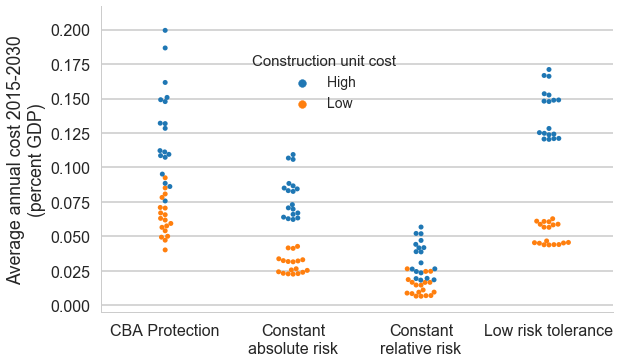

In [226]:
time_horizon = 2030

toplot = average_per_year_sumcoastcountries
toplot = toplot.reset_index()
toplot = toplot.loc[toplot.time_horizon==2030,:]
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")

toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp

toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk','Constant Rel. Flood Risk':"Constant\nrelative risk"})

toplot['adacost'] = toplot.adacost.str.replace("Construction Unit Cost","")

g = sns.factorplot(x='ada',y='protection_inv_over_gdp', data=toplot,hue='adacost', kind="swarm",dodge=False, size=6, aspect=1.5,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)")
g.add_legend(title="Construction unit cost",fontsize = 14, bbox_to_anchor=(0.5, 0.65), borderaxespad=0.)

plt.savefig("coastal_inv_2030_pc_coastal.png",ddpi=300,bbox_inches="tight")
plt.savefig("coastal_inv_2030_pc_coastal.pdf",bbox_inches="tight")

In [227]:
toplot.loc[toplot.ada=="Constant\nrelative risk","protection_inv_over_gdp"].describe()

count    36.000000
mean      0.024218
std       0.014554
min       0.006674
25%       0.013847
50%       0.019556
75%       0.032849
max       0.056824
Name: protection_inv_over_gdp, dtype: float64

In [228]:
toplot.protection_inv_over_gdp.describe()

count    144.000000
mean       0.067555
std        0.045709
min        0.006674
25%        0.031428
50%        0.058012
75%        0.093210
max        0.199403
Name: protection_inv_over_gdp, dtype: float64

## figure 5.3

C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


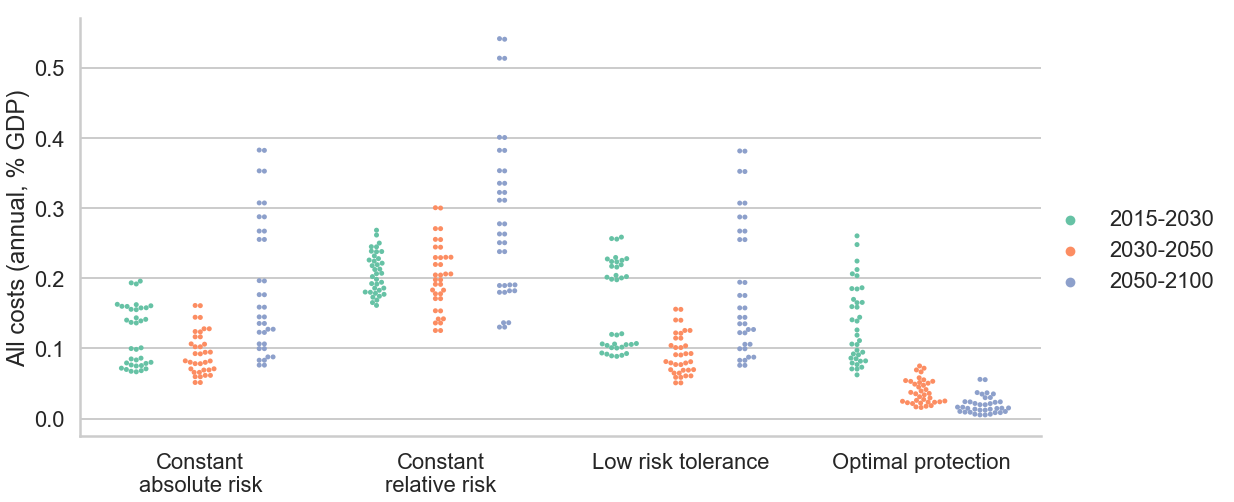

In [53]:
toplot = average_per_year_sumcountries.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]

toplot["time_horizon"] = toplot.time_horizon.replace({2030:"2015-2030",2050:"2030-2050",2100:"2050-2100"})
toplot["tot_cost_over_gdp"] = 100*toplot.tot_cost_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk',\
                                    'Constant Rel. Flood Risk':"Constant\nrelative risk",\
                                   'CBA Protection':"Optimal protection"})



g = sns.factorplot(x='ada',y='tot_cost_over_gdp', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=8, aspect=1.9,\
                  legend=False, palette = "Set2")

g.set_axis_labels("", "All costs (annual, % GDP)")
g.add_legend(title="")

plt.savefig("coastal_allcosts_pc_time_fig53.png",ddpi=300,bbox_inches="tight")
plt.savefig("coastal_allcosts_pc_time_fig53.pdf")

plt.savefig("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 5\\fig5_3.eps")
toplot.to_csv("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 5\\fig5_3.csv")

## equivalent of figure 5.3 with only countries with coasts

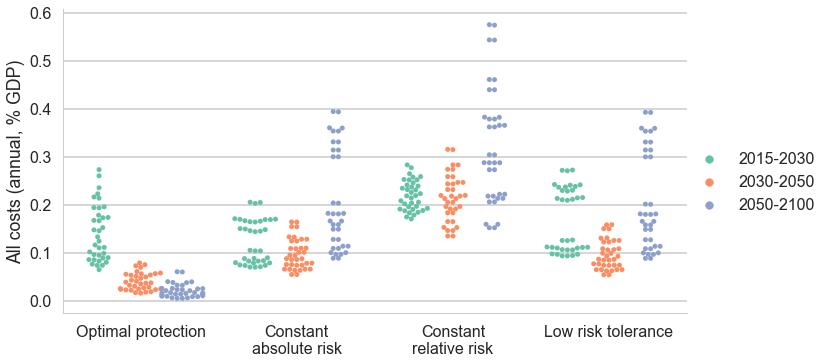

In [240]:
toplot = average_per_year_sumcoastcountries.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]

toplot["time_horizon"] = toplot.time_horizon.replace({2030:"2015-2030",2050:"2030-2050",2100:"2050-2100"})
toplot["tot_cost_over_gdp"] = 100*toplot.tot_cost_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk',\
                                    'Constant Rel. Flood Risk':"Constant\nrelative risk",\
                                   'CBA Protection':"Optimal protection"})



g = sns.factorplot(x='ada',y='tot_cost_over_gdp', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False, palette = "Set2")

g.set_axis_labels("", "All costs (annual, % GDP)")
g.add_legend(title="")

plt.savefig("coastal_allcosts_pc_time_coasts.png",ddpi=300,bbox_inches="tight")
plt.savefig("coastal_allcosts_pc_time_coasts.pdf")

In [241]:
toplot.tot_cost_over_gdp.describe()

count    432.000000
mean       0.156078
std        0.104644
min        0.005701
25%        0.078956
50%        0.135335
75%        0.214687
max        0.575377
Name: tot_cost_over_gdp, dtype: float64

## Figure 5.6

C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


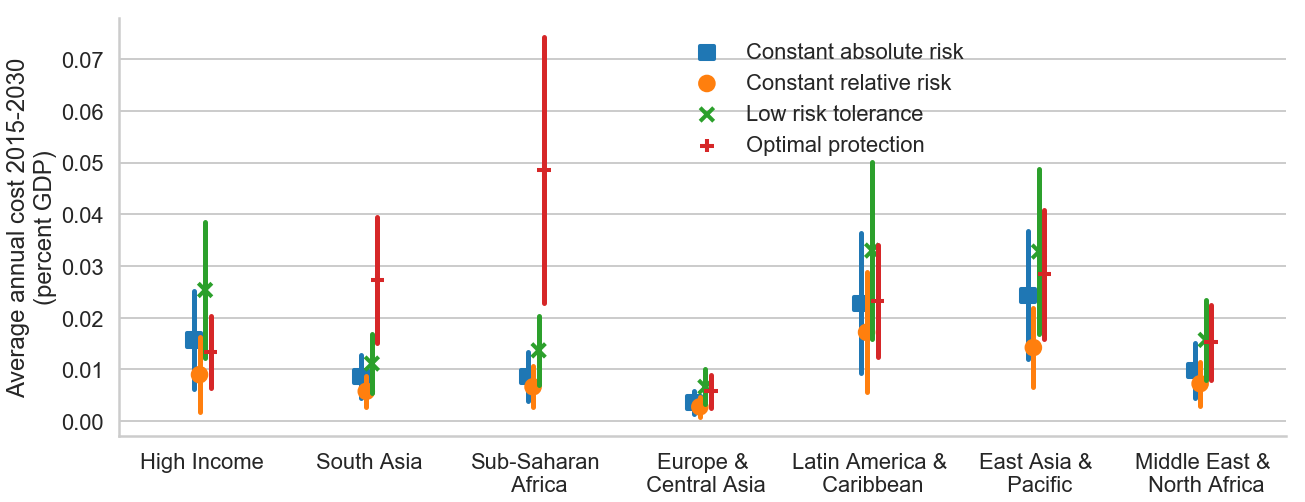

In [54]:
toplot = byregions_includesrich.protection_inv_over_gdp.mean(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['wbregionname'] = toplot['wbregionname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")
toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant absolute risk',\
                                    'Constant Rel. Flood Risk':"Constant relative risk",\
                                   'CBA Protection':"Optimal protection"})

g = sns.factorplot(x='wbregionname',y='protection_inv_over_gdp', hue= 'ada', data=toplot, kind="point",dodge=True,join=False,\
                  errwidth=5, markers=["s",'o','x','+'],height=8, ci="sd", aspect=2.3, legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.6, 0.7), borderaxespad=0.)

plt.savefig("coastal_inv_region_pc_dev_fig56.png",ddpi=300,bbox_inches="tight")
plt.savefig("coastal_inv_region_pc_dev_fig56.pdf")

plt.savefig("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 5\\fig5_6.eps")
toplot.to_csv("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 5\\fig5_6.csv")

In [233]:
toplot.columns

Index(['wbregionname', 'rcp', 'ada', 'ssp', 'adacost', 'riverprotection',
       'protection_inv_over_gdp'],
      dtype='object')

In [235]:
toplot.loc[(toplot.wbregionname=="Sub-Saharan\n Africa")&(toplot.ada=="Optimal protection"),"protection_inv_over_gdp"].describe()

count    36.000000
mean      0.048498
std       0.026103
min       0.015786
25%       0.030894
50%       0.040828
75%       0.062811
max       0.109133
Name: protection_inv_over_gdp, dtype: float64

In [239]:
toplot.groupby(["wbregionname","ada"]).protection_inv_over_gdp.mean()

wbregionname                  ada                   
East Asia &\n Pacific         Constant absolute risk    0.024297
                              Constant relative risk    0.014210
                              Low risk tolerance        0.032779
                              Optimal protection        0.028389
Europe &\n Central Asia       Constant absolute risk    0.003620
                              Constant relative risk    0.002751
                              Low risk tolerance        0.006608
                              Optimal protection        0.005734
Latin America &\n Caribbean   Constant absolute risk    0.022758
                              Constant relative risk    0.017161
                              Low risk tolerance        0.032974
                              Optimal protection        0.023171
Middle East &\n North Africa  Constant absolute risk    0.009788
                              Constant relative risk    0.007219
                              Low ris

## equivalent of figure 5.6 with only coastal countries

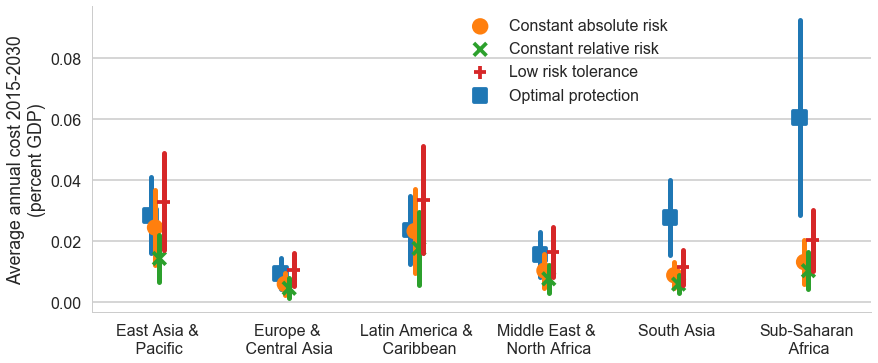

In [246]:
toplot = byregions_coasts.protection_inv_over_gdp.mean(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['wbregionname'] = toplot['wbregionname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")
toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant absolute risk',\
                                    'Constant Rel. Flood Risk':"Constant relative risk",\
                                   'CBA Protection':"Optimal protection"})

g = sns.factorplot(x='wbregionname',y='protection_inv_over_gdp', hue= 'ada', data=toplot, kind="point",dodge=True,join=False,\
                  errwidth=5, markers=["s",'o','x','+'],size=6, ci="sd", aspect=2.1, legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.6, 0.7), borderaxespad=0.)

#plt.savefig("coastal_inv_region_{}pc_dev.png".format(time_horizon),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_region_{}pc_dev.pdf".format(time_horizon))

In [247]:
toplot.protection_inv_over_gdp.describe()

count    864.000000
mean       0.018197
std        0.016684
min        0.001180
25%        0.007190
50%        0.013155
75%        0.023036
max        0.135958
Name: protection_inv_over_gdp, dtype: float64

In [252]:
toplot.groupby(["wbregionname","ada"]).protection_inv_over_gdp.mean()+toplot.groupby(["wbregionname","ada"]).protection_inv_over_gdp.std()

wbregionname                  ada                   
East Asia &\n Pacific         Constant absolute risk    0.037095
                              Constant relative risk    0.022171
                              Low risk tolerance        0.049240
                              Optimal protection        0.041126
Europe &\n Central Asia       Constant absolute risk    0.009715
                              Constant relative risk    0.007859
                              Low risk tolerance        0.016117
                              Optimal protection        0.014594
Latin America &\n Caribbean   Constant absolute risk    0.037370
                              Constant relative risk    0.029678
                              Low risk tolerance        0.051419
                              Optimal protection        0.034901
Middle East &\n North Africa  Constant absolute risk    0.016006
                              Constant relative risk    0.012227
                              Low ris

## Adapatation deficit

In [ ]:
originaldata = originaldata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])

This one assumes all the investments are made in 2015

In [261]:
originaldata.loc[(originaldata.time==2010)|(originaldata.time==2015),"protection_investment_cost"].sum(level=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection']).unstack("rcp")["RCP 2.6 (Low ice melting)"].unstack("ada")[["CBA Protection","Constant Protection Levels"]].diff(axis=1)["Constant Protection Levels"].mean(level=["locationid","locationname"])*5/2

locationid  locationname              
EAP         East Asia & Pacific          -281334.499131
ECA         Europe & Central Asia          -4931.901700
LAC         Latin America & Caribbean     -46377.634732
MNA         Middle East & North Africa    -19678.769453
SAS         South Asia                   -134110.851053
SSA         Sub-Saharan Africa            -73075.473881
YHI         High Income                  -141757.783726
Name: Constant Protection Levels, dtype: float64

This one assumes investments are spread over 2015-2030, so investments in 2015 are smaller

In [267]:
sumcountries_deficit = byregions.reset_index("time")
sumcountries_deficit.loc[(sumcountries_deficit.time==2010)|(sumcountries_deficit.time==2015),"protection_investment_cost_corrected"].sum(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection']).unstack("rcp")["RCP 2.6 (Low ice melting)"].unstack("ada")[["CBA Protection","Constant Protection Levels"]].diff(axis=1)["Constant Protection Levels"].mean(level=['wbregionname'])*5

wbregionname
East Asia & Pacific          -74804.406225
Europe & Central Asia         -1778.988440
Latin America & Caribbean       -68.616921
Middle East & North Africa    -6333.662251
South Asia                   -49197.970034
Sub-Saharan Africa           -28468.912251
Name: Constant Protection Levels, dtype: float64

## Best scenario

### absolute numbers all developing countries together

In [274]:
newdata.reset_index().columns

Index(['index', 'locationid', 'locationname', 'rcp', 'ada', 'ssp', 'adacost',
       'riverprotection', 'time', 'time_horizon', 'd',
       'protection_investment_cost_disc', 'protection_maintenance_cost_disc',
       'seafloodcost_disc', 'country_name', 'wbregion', 'wbregionname',
       'wbincome', 'wbincomename', 'wblending', 'wbhipc'],
      dtype='object')

In [285]:
dev_world = newdata.loc[newdata.wbregion!="YHI",:].set_index(['locationid', 'locationname','wbregionname', 'rcp', 'ada', 'ssp', 'adacost',
       'riverprotection', 'time', 'time_horizon', 'd'])[['protection_investment_cost_disc', 'protection_maintenance_cost_disc',
       'seafloodcost_disc']].sum(level=['rcp', 'ada', 'ssp', 'adacost',
       'riverprotection', 'time_horizon', 'd'])

In [321]:
temp = dev_world[['protection_investment_cost_disc', 'protection_maintenance_cost_disc']].reset_index("time_horizon")
1/(2030-2015)*temp.loc[temp.time_horizon==2030,['protection_investment_cost_disc', 'protection_maintenance_cost_disc']].describe()

,protection_investment_cost_disc,protection_maintenance_cost_disc
count,12.000000,12.000000
mean,41520.287638,26209.360093
std,32406.551303,12533.523892
min,3898.309135,11741.113525
25%,16302.138597,13479.263294
50%,32353.866779,28242.771350
75%,58557.171802,36927.546458
max,149655.666988,54722.145413


In [286]:
best_scenario = dev_world.reset_index()

select = (best_scenario.ada=="CBA Protection")&(best_scenario.ssp=="SSP2")&(best_scenario.adacost=='High Adaptation Unit Cost')&(best_scenario.riverprotection=='CBA River Protection')\
&(best_scenario.time_horizon==2030)&(best_scenario.d==0.06)

best_scenario = best_scenario.loc[select,:]

In [287]:
1/(2030-2015)*10**(-3)*best_scenario.set_index("rcp")[["protection_maintenance_cost_disc","protection_investment_cost_disc"]]

,protection_maintenance_cost_disc,protection_investment_cost_disc
rcp,,
RCP 2.6 (Low ice melting),38.935944,74.800154
RCP 4.5 (Medium ice melting),42.742323,90.871157
RCP 8.5 (High ice melting),49.780093,128.668147


### GDP ratios all developing countries

In [288]:
sumcountries.reset_index().columns

Index(['rcp', 'ada', 'ssp', 'adacost', 'riverprotection', 'time',
       'protection_investment_cost_corrected', 'protection_maintenance_cost',
       'gdp', 'seafloodcost', 'protection_inv_over_gdp',
       'protection_maint_over_gdp', 'protection_cost_over_gdp',
       'residual_risk_over_gdp', 'tot_cost_over_gdp'],
      dtype='object')

In [289]:
best_scenario = sumcountries.reset_index()

select = (best_scenario.ada=="CBA Protection")&(best_scenario.ssp=="SSP2")&(best_scenario.adacost=='High Adaptation Unit Cost')&(best_scenario.riverprotection=='CBA River Protection')&\
(best_scenario.time<2031)

best_scenario = best_scenario.loc[select,['rcp','time','protection_inv_over_gdp', 'protection_maint_over_gdp']]

In [290]:
100*best_scenario.set_index(["time","rcp"]).mean(level=["rcp"])

,protection_inv_over_gdp,protection_maint_over_gdp
rcp,,
RCP 2.6 (Low ice melting),0.090536,0.059237
RCP 4.5 (Medium ice melting),0.108933,0.063478
RCP 8.5 (High ice melting),0.150497,0.071299


In [322]:
0.15+0.18

0.32999999999999996

### same with only coastal countries

In [291]:
best_scenario = sumcoastcountries.reset_index()

select = (best_scenario.ada=="CBA Protection")&(best_scenario.ssp=="SSP2")&(best_scenario.adacost=='High Adaptation Unit Cost')&(best_scenario.riverprotection=='CBA River Protection')&\
(best_scenario.time<2031)

best_scenario = best_scenario.loc[select,['rcp','time','protection_inv_over_gdp', 'protection_maint_over_gdp']]

In [292]:
100*best_scenario.set_index(["time","rcp"]).mean(level=["rcp"])

,protection_inv_over_gdp,protection_maint_over_gdp
rcp,,
RCP 2.6 (Low ice melting),0.095451,0.062502
RCP 4.5 (Medium ice melting),0.114739,0.066908
RCP 8.5 (High ice melting),0.158433,0.075109


### per region

In [293]:
best_scenario = byregions.reset_index()

select = (best_scenario.ada=="CBA Protection")&(best_scenario.ssp=="SSP2")&(best_scenario.adacost=='High Adaptation Unit Cost')&(best_scenario.riverprotection=='CBA River Protection')&\
(best_scenario.time<2031)&(best_scenario.rcp=='RCP 4.5 (Medium ice melting)')

best_scenario = best_scenario.loc[select,['rcp','time','protection_inv_over_gdp', 'protection_maint_over_gdp','wbregionname']]

In [295]:
100*best_scenario.set_index(["time","rcp","wbregionname"]).mean(level=["wbregionname"])

,protection_inv_over_gdp,protection_maint_over_gdp
wbregionname,,
East Asia & Pacific,0.115889,0.077196
Europe & Central Asia,0.016187,0.007500
Latin America & Caribbean,0.076603,0.078130
Middle East & North Africa,0.066328,0.031308
South Asia,0.138124,0.043896
Sub-Saharan Africa,0.221624,0.077719
